# Logistic regression with PyMC3

### Loading Libraries

In [4]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd
import pandas_datareader.data as web

# Data Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Scipy Stats
from scipy import stats
import scipy.stats as stats

# StatsModels
import statsmodels.formula.api as smf

# Warnings
import warnings

# Path
from pathlib import Path

# Pickle
import pickle

# Scikit-Learn
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Theano
# import theano

# PyMC3
# import pymc3 as pm

# Arviz
import arviz

# IPytohn
from IPython.display import HTML

In [5]:
%matplotlib inline

In [6]:
sns.set_style('whitegrid')

In [8]:
data_path = Path('data')

fig_path = Path('figures')

model_path = Path('models')

for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

### The Data: Recessions & Leading Indicators

#### Download from FRED

In [9]:
indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCINONFINLEVERAGE', 'UMCSENT']

var_names = ['recession', 'yield_curve', 'financial_conditions', 'leverage', 'sentiment']

In [10]:
features = var_names[1:]

label = var_names[0]

In [11]:
var_display = ['Recession', 'Yield Curve', 'Financial Conditions', 'Leverage', 'Sentiment']

col_dict = dict(zip(var_names, var_display))

In [13]:
data = (web.DataReader(indicators, 'fred', 1980, 2020)
        .ffill()
        .resample('ME')
        .last()
        .dropna())

data.columns = var_names

In [14]:
data.loc[:, features] = scale(data.loc[:, features])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 1982-01-31 to 2020-01-31
Freq: ME
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             457 non-null    float64
 1   yield_curve           457 non-null    float64
 2   financial_conditions  457 non-null    float64
 3   leverage              457 non-null    float64
 4   sentiment             457 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB


#### Quick Exploration

In [16]:
mi = []

months = list(range(1, 25))

for month in months:
    df_ = data.copy()
    df_[label] = df_[label].shift(-month)
    df_ = df_.dropna()
    mi.append(mutual_info_classif(df_.loc[:, features], df_[label]))

mi = pd.DataFrame(mi, columns=features, index=months)

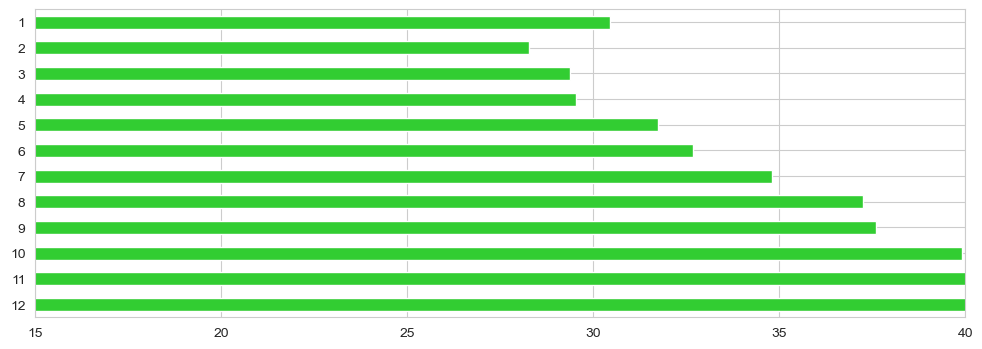

In [19]:
mi.sum(1).mul(100).iloc[:12].sort_index(ascending=False).plot.barh(figsize=(12, 4), xlim=(15, 40), color='limegreen');
plt.show()

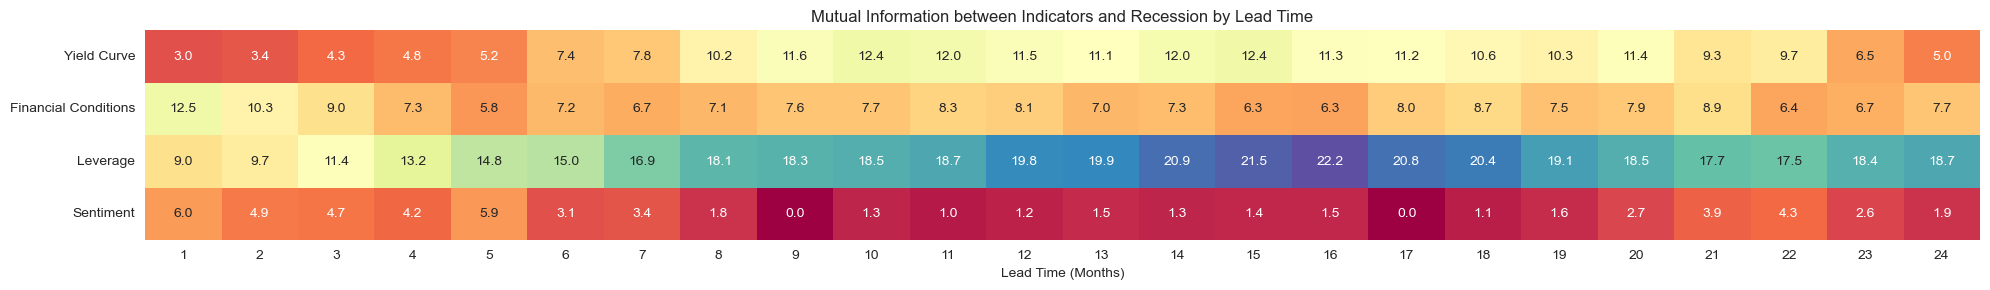

In [27]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(mi.rename(columns=col_dict).T*100, cmap='Spectral', ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
fig.tight_layout();
plt.show()

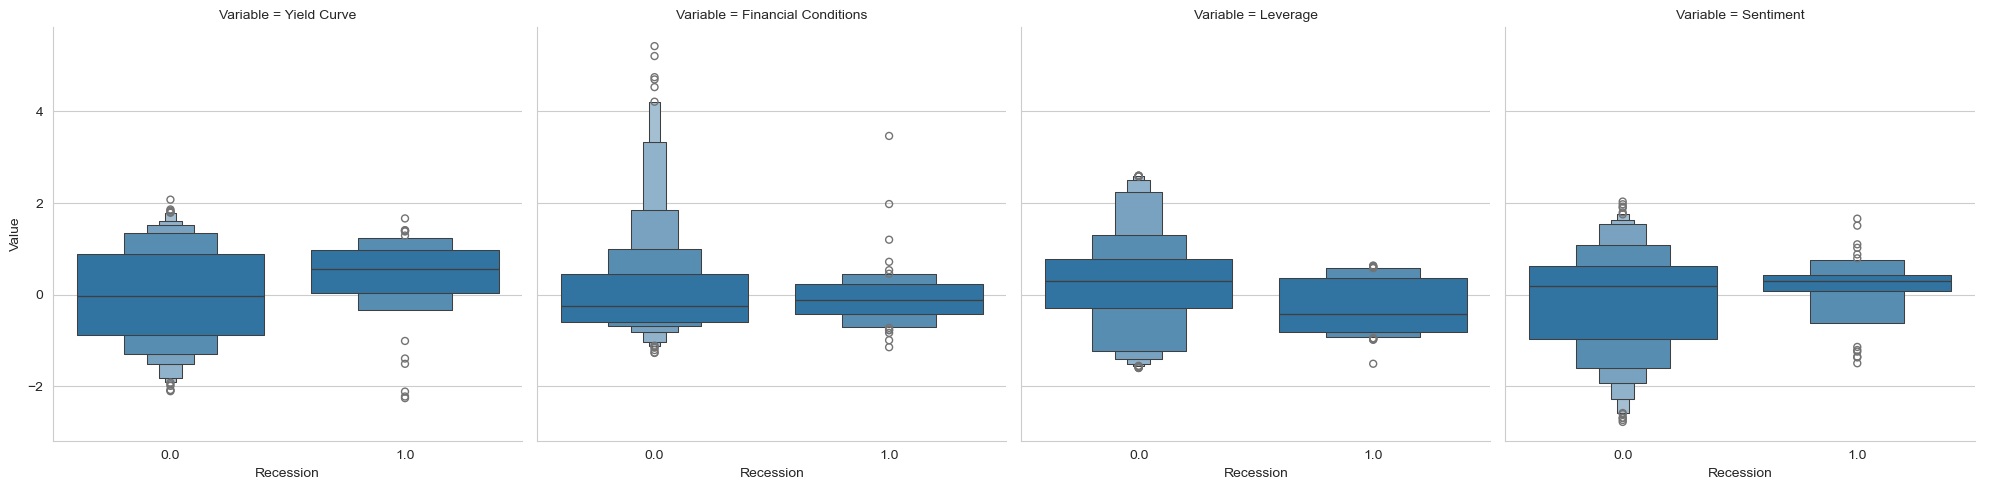

In [31]:
data[label] = data[label].shift(-12)
data = data.dropna()
data_ = pd.melt(data.rename(columns=col_dict), id_vars='Recession').rename(columns=str.capitalize)
g = sns.catplot(x='Recession', y='Value', col='Variable', data=data_, kind='boxen');
plt.show()

In [32]:
# Features
X = data.loc[:, features]

# Target
y = data[label]

In [33]:
y.value_counts()

recession
0.0    324
1.0     49
Name: count, dtype: int64

In [34]:
data.to_csv('data/recessions.csv')

## Loading from Disk

In [35]:
data = pd.read_csv('data/recessions.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 1982-01-31 to 2013-01-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             373 non-null    float64
 1   yield_curve           373 non-null    float64
 2   financial_conditions  373 non-null    float64
 3   leverage              373 non-null    float64
 4   sentiment             373 non-null    float64
dtypes: float64(5)
memory usage: 17.5+ KB


### Models

In [36]:
simple_model = 'recession ~ yield_curve + leverage'

full_model =  simple_model + ' + financial_conditions + sentiment'

## MAP Inference

### Manual Model Specification

In [38]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + 
                             beta_1 * data.yield_curve +
                             beta_2 * data.leverage)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', 
                 p=likelihood, 
                 observed=data.recession)

In [39]:
manual_logistic_model.model

In [40]:
pm.model_to_graphviz(manual_logistic_model)

In [41]:
# opionally: persist
# graph = pm.model_to_graphviz(manual_logistic_model)
# graph.save('log_reg.dot')

#### Running Inference

In [42]:
with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

In [43]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

In [44]:
print_map(manual_map_estimate)

#### GLM Model

In [45]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            data,
                            family=pm.glm.families.Binomial())

In [46]:
pm.model_to_graphviz(logistic_model)

#### MAP Estimate

In [47]:
with logistic_model:
    map_estimate = pm.find_MAP()

In [48]:
model = smf.logit(formula=simple_model, data=data)
result = model.fit()
print(result.summary())

In [49]:
print_map(map_estimate)

In [50]:
result.params

### Markov Chain Monte Carlo

In [51]:
def plot_traces(traces, burnin=2000):
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')

#### Model Definition

In [52]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

In [53]:
logistic_model.basic_RVs

#### Metropolis-Hastings

In [54]:
with logistic_model:
    trace_mh = pm.sample(tune=1000,
                         draws=5000,
                         step=pm.Metropolis(),
                         cores=4)

#### Inspecting Trace

In [55]:
plot_traces(trace_mh, burnin=0)

In [56]:
pm.trace_to_dataframe(trace_mh).info()

#### Forwarding Training

In [57]:
with logistic_model:
    trace_mh = pm.sample(draws=100000,
                         step=pm.Metropolis(),
                         trace=trace_mh)

In [58]:
plot_traces(trace_mh, burnin=0)

In [60]:
optionally: persist
with open('logistic_model_mh.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model, 'trace': trace_mh}, buff)

In [61]:
optionally: restore persisted model
with open('logistic_model_mh.pkl', 'rb') as buff:
    pickled_data = pickle.load(buff)  

logistic_model, trace_mh = pickled_data['model'], pickled_data['trace']

In [62]:
arviz.summary(trace_mh)

### NUTS sampler

#### Drawing Small Number of Samples

In [63]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           chains=4,
                           cores=1,
                           random_seed=42)

In [64]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)

trace_df.info()

In [65]:
plot_traces(trace_NUTS, burnin=0)

#### Keep Training

In [66]:
draws = 50000

chains = 4

with logistic_model:
    trace_NUTS = pm.sample(draws=draws, 
                           tune=tune,
                           init='adapt_diag',
                           trace=trace_NUTS,
                           chains=chains, 
                           cores=1,
                           random_seed=42)

In [67]:
plot_traces(trace_NUTS, burnin=1000)

#### Persisting Results

In [68]:
optional
with open('logistic_model_nuts.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model,
                 'trace': trace_NUTS}, buff)

In [69]:
with open('logistic_model_nuts.pkl', 'rb') as buff:
    pickled_data = pickle.load(buff)  

logistic_model, trace_NUTS = pickled_data['model'], pickled_data['trace']

#### Combining Traces

In [70]:
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(
    drop=True).assign(chain=lambda x: x.index // draws)

trace_df = pd.concat([trace_df.assign(samples=100),
                      df.assign(samples=len(df) + len(trace_df))])
trace_df.info()

#### Visualizing both Traces

In [71]:
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])

trace_df_long.info()

In [72]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples',
                  hue='chain', sharex='col', sharey=False)

g = g.map(sns.distplot, 'value', hist=False, rug=False);

plt.show()

In [73]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()

print(result.summary())

In [74]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params).to_csv(model_path / 'trace_nuts.csv')

In [75]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params)

### Computing Credible Intervals

In [76]:
def get_credible_int(trace, param):
    b = trace[param]
    lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
    lb, ub = np.exp(lb), np.exp(ub)
    return b, lb, ub

In [77]:
b = trace_NUTS['yield_curve']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)

print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

In [78]:
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')

print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

In [80]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[0])
axes[0].set_title(f'Yield Curve: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[0].axvspan(lb, ub, alpha=0.5, color='gray')

b, lb, ub = get_credible_int(trace_NUTS, 'leverage')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[1])
axes[1].set_title(f'Leverage: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[1].axvspan(lb, ub, alpha=0.5, color='gray')

fig.suptitle('Credible Intervals', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);
plt.show()

## Variational Inference

### Run Automatic Differentation Variational Inference (ADVI)

In [81]:
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000, 
                    callbacks=[callback])

#### Persisting Result

In [82]:
optional
with open(logistic_model_advi.pkl', 'wb') as buff:
    pickle.dump({'model': logistic_model,
                 'approx': approx}, buff)

#### Sample from Approximated Distribution

In [83]:
trace_advi = approx.sample(10000)

In [84]:
arviz.summary(trace_advi)

In [85]:
arviz.summary(trace_advi).to_csv(model_path / 'trace_advi.csv')

### Model Diagnostics

#### Energy Plot

In [110]:
arviz.plot_energy(trace_NUTS);

#### Forest Plot

In [111]:
arviz.plot_forest(trace_NUTS);

In [89]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
arviz.plot_forest(trace_NUTS, ax=axes[0])
axes[0].set_title('Forest Plot')

arviz.plot_energy(trace_NUTS, ax=axes[1])
axes[1].set_title('Energy Plot')

fig.tight_layout();
plt.show()

#### Posterior Predictive Checks

In [94]:
ppc = pm.sample_posterior_predictive(trace_NUTS, samples=500, model=logistic_model)

In [95]:
ppc['y'].shape

In [96]:
y_score = np.mean(ppc['y'], axis=0)

In [97]:
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=data.recession)

### Prediction

#### Train-Test Split

In [98]:
X = data[['yield_curve']]
labels = X.columns
y = data.recession
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

#### Creating Shared `theano` Variable

In [99]:
X_shared = theano.shared(X_train.values)

#### Setting Logistic Model

In [100]:
with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared, 
               labels=labels,
               y=y_train, 
               family=pm.glm.families.Binomial())

### Running NUTS Sampler

In [101]:
with logistic_model_pred:
    pred_trace = pm.sample(draws=10000, 
                           tune=1000,
                           chains=2,
                           cores=1,
                           init='adapt_diag')

### Replacing Shared Variable with Test Set

In [112]:
X_shared.set_value(X_test)

In [113]:
ppc = pm.sample_posterior_predictive(pred_trace,
                                     model=logistic_model_pred,
                                     samples=100)

#### Checking AUC Score

In [114]:
y_score = np.mean(ppc['y'], axis=0)

roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=y_test)

In [115]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [116]:
x = X_test.yield_curve

fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=x, y=β.mean())

# error bars on the estimate
plt.vlines(x, *β.interval(0.95))

# actual outcomes
ax.scatter(x=x, y=y_test, marker='x')

# True probabilities
x_ = np.linspace(x.min()*1.05, x.max()*1.05, num=100)
ax.plot(-x_, invlogit(x_), linestyle='-')

ax.set_xlabel('Yield Curve')
ax.set_ylabel('Recession')
ax.invert_xaxis()
fig.tight_layout();

### MCMC Sampler Animation

#### Setup

In [117]:
# Number of MCMC iteration to animate.
burnin = 1000
samples = 1000

var1 = 'yield_curve'
var1_range = (trace_df[var1].min() * .95, trace_df[var1].max() * 1.05)

var2 = 'sentiment'
var2_range = (trace_df[var2].min() * .95, trace_df[var2].max() * 1.05)

In [118]:
Writer = animation.writers['ffmpeg']

writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [119]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

#### NUTS Samples

In [120]:
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

In [121]:
with logistic_model:
    nuts_trace = pm.sample(draws=samples, tune=burnin,
                      init='adapt_diag',
                      chains=1)
    trace_df = pm.trace_to_dataframe(nuts_trace)

trace_df.to_csv('trace.csv', index=False)
trace_df = pd.read_csv('trace.csv')

print(trace_df.info())

In [122]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]


anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True);

# save
# anim.save('nuts.mp4', writer=writer)
# or display; either requres ffmpeg installation
HTML(anim.to_html5_video())
plt.show()

#### Metropolis-Hastings Samples

In [123]:
with logistic_model:
    step = pm.Metropolis()
    mh_trace = pm.sample(draws=samples, tune=burnin,
                      step=step,
                      chains=1)
    trace_df = pm.trace_to_dataframe(mh_trace)

In [124]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

HTML(anim.to_html5_video())